# 3_Transform a matriz with raw counts to TPMs normalization

Made by: Cynthia Soto <br>
Date: March 17th 2021 <br>
Last md: March 19th 2021 <br>

Converted absolute counts to TPMs count (to make the samples comparable)  <br>

**Assumptions:**<br>
1. You have a matrix expression intergrated with the raw count.
2. You have a file with the gene_lenghts (run first <Gene_length_extraction_from_GTF.ipynb> if you do not have the lenghts vector) 


In [16]:
# Libraries required
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bioinfokit.analys import norm, get_data    ##https://github.com/reneshbedre/bioinfokit 
# load sugarcane RNA-seq expression dataset (Published in Bedre et al., 2019)
# Requires: scikit-learn, pandas, seaborn, matplotlib-venn, statsmodels, textwrap3, numpy, scipy, tabulate, matplotlib, adjustText

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [53]:
#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the temporary files. 

###   Here, I am choosing what dataset I am going to process
#general_titles="healthy"
general_titles=" infected "

try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")    

#print(os.listdir(os.getcwd())       

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data


### Transform raw counts to transcript per million "TPM"

Notes:
   1. TPM considers the gene length for normalization
   2. TPM is suitable for sequencing protocols where reads sequencing depends on gene length <br>
More details: https://www.reneshbedre.com/blog/expression_units.html

### Declare functions

In [18]:
# Set ID index as "ID" to a describe() function in a df
def df_with_label_ID(df_stat):
    df_stat.reset_index(level=0, inplace=True)
    df_stat.rename(columns={'index': 'ID'}, inplace=True)
    
    ## use this chunk if you want to give IDs to a describe() functions from a external meta-data
    #     file='../meta-data/ID_samples.csv'
    #     df_meta=pd.read_csv(file, sep='\,', engine='python', usecols=[0,4]) 
    #     #print(df_meta.head(5))
    #     ## merge by sample field
    #     df = pd.merge(df, df_meta, on="sample")    
    df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    return df_stat 

In [41]:
# plot a bar chart from the describe() function of the specific df
def plot_intercuartile_bar(df, title, y_label):
    ax = df.plot(x="ID", y="75%", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

In [44]:
# plot a line chart from the mean and STD from the describe() function of the specific df
def plot_mean_sdev_line(df, title, y_label):
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    return

In [51]:
# Plot the distributions: values are raw data - not normalized 
def plot_KDE(df, samples, title, y_label):
    plt.style.use('seaborn-whitegrid')
    kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})
    plt.figure(figsize=(10,7), dpi= 80)
    for file in samples:
        sample_data = df_nozeros[file].tolist()
        #print(sample_data[1:10])
        #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
        sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 
    plt.title('A.thaliana ' + title + ': Histogram with KDE (TPM normalization)',fontsize=14);
    plt.xlabel(y_label,fontsize=14);
    plt.ylabel('Probability Density',fontsize=14);
    ## add arbitrary lines to canvas
    #plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
    #plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
    plt.legend(loc='center right',fontsize=12);    
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

**Load your expression matrix**

In [54]:
if general_titles == 'healthy':
    df_expr=pd.read_csv("all_healthy_raw_8ceros_drop.csv", header=0, sep='\t')
else:
    df_expr=pd.read_csv("all_infected_raw_17ceros_drop.csv", header=0, sep='\t')    ## ,nrows=100  usecols=[1,3] / Araport11_GFF3.gff

df_expr.head(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127,0
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13,0
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647,0
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284,0
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525,0


In [55]:
# delete not useful columns
df_expr.drop(['zero-counter'], axis='columns', inplace=True)   #, 'Unnamed: 0'
df_expr.head(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525


**load the gene lenght file**

In [56]:
df_gl=pd.read_csv("../meta-data/Araport11_GFF3_genes_lenghts.csv",  usecols = ['Genes','gen_len'], header=0, sep='\t')    
df_gl.head(5)

,Genes,gen_len
0,AT1G01010,1871
1,AT1G01020,1752
2,AT1G01030,1077
3,AT1G01040,7561
4,AT1G01050,1289


**merge the gene length df with the expr matrix df**

In [58]:
## compare number of genes 
print(len(df_expr), len(df_gl))

24239 27655


With **merge** we can join data from 2 df<br>
The **how** argument to merge specifies how to determine which keys are to be included in the resulting table. If a key combination does not appear in either the left or right tables, the values in the joined table will be NA. 
Only the keys appearing in left and right are present (the intersection), since **how='inner'** by default.<br>
https://pandas.pydata.org/docs/user_guide/merging.html

In [59]:
result = pd.merge(df_expr, df_gl, on=["Genes", "Genes"])

In [60]:
len(result)

24239

In [61]:
result.head(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,gen_len
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127,1752
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13,1077
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647,7561
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284,1289
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525,3070


In [62]:
#result[['Genes','healthy30.1','healthy30','healthy12','gen_len']].head(10)
result.iloc[1:10, list(range(4)) + [-1]]

,Genes,Ss30.1,Bc12,Ch40.2,gen_len
1,AT1G01030,33,6,10,1077
2,AT1G01040,57,1057,631,7561
3,AT1G01050,18,1246,258,1289
4,AT1G01060,3,798,488,3070
5,AT1G01070,4,89,96,1980
6,AT1G01080,67,1370,156,1287
7,AT1G01090,406,1367,643,1462
8,AT1G01100,94,773,605,671
9,AT1G01110,0,10,2,2256


In [63]:
## take a look about the distributions for this specific expression dataset
#result['gen_len'].plot.hist(orientation="horizontal");   #, cumulative=True

In [64]:
# make gene column as index column
df = result.set_index('Genes')
df.head(5)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,gen_len
Genes,,,,,,,,,,,,,,,,,,
AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127,1752
AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13,1077
AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647,7561
AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284,1289
AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525,3070


### now, normalize raw counts using TPM method

In [65]:
# gene length must be in bp
nm = norm()
nm.tpm(df=df, gl='gen_len')
# get TPM normalized dataframe
tpm_df = nm.tpm_norm

In [66]:
tpm_df.head(5)
# output

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
Genes,,,,,,,,,,,,,,,,,
AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940
AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041
AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855


In [67]:
## chk the result with the total sum by column 
tpm_df.sum(axis = 0, skipna = True) 

Ss30.1    1.000e+06
Bc12      1.000e+06
Ch40.2    1.000e+06
Ch22.2    1.000e+06
Ch22.1    1.000e+06
Ch22      1.000e+06
Ss30.2    1.000e+06
Ch22.3    1.000e+06
Bc12.1    1.000e+06
Bc24.1    1.000e+06
Bc18.1    1.000e+06
Ch40.3    1.000e+06
Ch40.1    1.000e+06
Bc18      1.000e+06
Bc24      1.000e+06
Ss30      1.000e+06
Ch40      1.000e+06
dtype: float64

In [68]:
tpm_df.to_csv("../results-data/matrices_de_expresion/all_"+ general_titles +"_TPM.csv", index=True, header=True)

### Some stats of the new df

In [69]:
df_plot=tpm_df.describe().T
df_plot.head(5)

,count,mean,std,min,25%,50%,75%,max
Ss30.1,24239.0,41.256,369.459,0.0,0.000,0.921,8.626,30046.794
Bc12,24239.0,41.256,258.977,0.0,0.462,7.803,25.862,21314.028
Ch40.2,24239.0,41.256,210.344,0.0,0.533,6.667,25.597,10852.459
Ch22.2,24239.0,41.256,230.030,0.0,0.693,10.173,32.238,21455.952
Ch22.1,24239.0,41.256,230.732,0.0,0.661,9.674,30.751,18793.409


In [70]:
## call the fuction df_with_label_ID
df_plot = df_with_label_ID(df_plot)
df_plot.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
1,Bc12,24239.0,41.256,258.977,0.0,0.462,7.803,25.862,21314.028
8,Bc12.1,24239.0,41.256,275.529,0.0,0.428,7.481,25.017,23373.501
13,Bc18,24239.0,41.256,237.583,0.0,0.393,7.723,26.707,13089.181
10,Bc18.1,24239.0,41.256,253.646,0.0,0.449,7.477,25.485,18660.458
14,Bc24,24239.0,41.256,227.828,0.0,1.248,9.229,29.556,18666.461


In [71]:
df_plot.to_csv("../results-data/statistics/all_TPM_"+ general_titles +"_stats.csv", index=False, header=True)

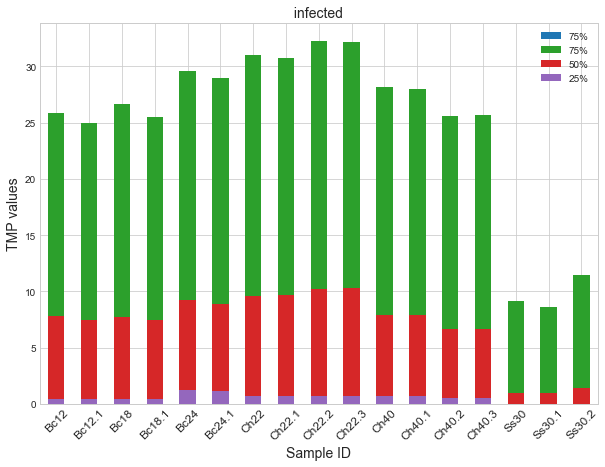

In [72]:
plot_intercuartile_bar(df_plot, general_titles, 'TMP values' )

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


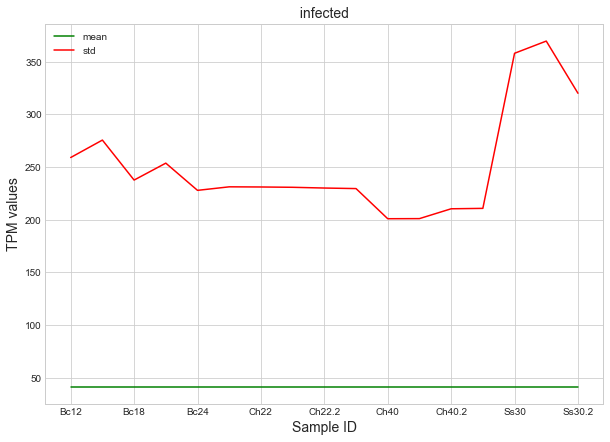

In [73]:
plot_mean_sdev_line(df_plot, general_titles,'TPM values')

### Check the number of zeros by sample after normalization

In [74]:
sr_ceros = tpm_df.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

In [91]:
type(sr_ceros)
sr_ceros.sort_values()

Bc24      2212
Bc24.1    2288
Ch40      3596
Ch40.1    3638
Ch40.3    3675
Ch40.2    3702
Ch22.1    3749
Ch22.2    3770
Ch22.3    3804
Ch22      3814
Bc12.1    3960
Bc12      4103
Bc18      4134
Bc18.1    4304
Ss30.2    6242
Ss30.1    7185
Ss30      7451
dtype: int64

### Check the number of zeros across all sample after normalization
Zeros will be counted by gene across all samples & a new column with the zero-counter will be appended to the matrix.

In [92]:
s_zeros=(tpm_df == 0).astype(int).sum(axis=1)
## Added a column to df1 with the counter of zeros
tpm_df['zero-counter'] = s_zeros
tpm_df.head(3)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
Genes,,,,,,,,,,,,,,,,,,
AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0


Here, we look for genes with n number of ceros

In [95]:
## Filter is looking for genes with 8 zeros across all samples in the healthy df (we have 8 samples for control)
##                   and genes with 17 zeros across all samples in the infected df (we have 17 samples infected)
if general_titles == 'healthy':
    is_zero = (tpm_df['zero-counter']>=8)     
    df_zero = tpm_df[is_zero]
else:
    is_zero = (tpm_df['zero-counter']>=17)     
    df_zero = tpm_df[is_zero]
print(df_zero.shape)
df_zero.head(7)
## save the result as tmp result

(0, 18)


,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
Genes,,,,,,,,,,,,,,,,,,


In [96]:
## Here, we count how many genes are not expressed in all the samples
df_zero.isin([0]).sum().head()

Ss30.1    0
Bc12      0
Ch40.2    0
Ch22.2    0
Ch22.1    0
dtype: int64

### Now explore the new distributions with the normalized data
Plot all the sample in one plot (histogram and KDE)

In [97]:
# load file to be plotted
print(os.getcwd())
df_nozeros = pd.read_csv("matrices_de_expresion/all_" + general_titles + "_TPM.csv", sep=',')  
df_nozeros.drop(['Genes'], axis=1, inplace = True)
df_nozeros.head(3)

/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data


,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


In [98]:
## Get sample list names
sample_lst=df_nozeros.columns
print(sample_lst)
df_nozeros.head(5)

Index(['Ss30.1', 'Bc12', 'Ch40.2', 'Ch22.2', 'Ch22.1', 'Ch22', 'Ss30.2',
       'Ch22.3', 'Bc12.1', 'Bc24.1', 'Bc18.1', 'Ch40.3', 'Ch40.1', 'Bc18',
       'Bc24', 'Ss30', 'Ch40'],
      dtype='object')


,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940
3,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041
4,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855


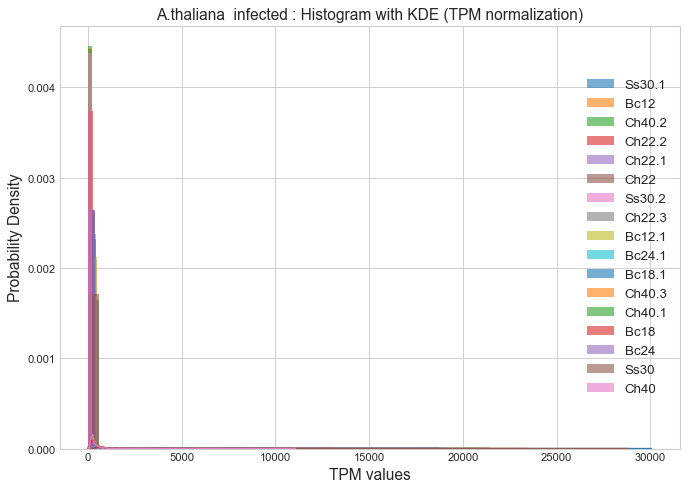

In [99]:
plot_KDE(df_nozeros, sample_lst, general_titles, 'TPM values')